In [2]:
!pip install segmentation-models-pytorch albumentations opencv-python

В данной лабораторной работе использовался кастомный датасет-класс `VOCDataset`, созданный на основе `VOCSegmentation` из `torchvision`.

### Что происходит:

- Загружается датасет VOC 2012 (train/val), при необходимости скачивается.
- Изображения и соответствующие маски преобразуются в `numpy`-массивы.
- Все значения маски, равные 255 (фон), заменяются на 0.
- Применяются аугментации с использованием библиотеки `Albumentations`.

### Преобразования (аугментации):

#### Для обучающей выборки:
- изменение размера до 256×256 пикселей;
- случайное горизонтальное отражение;
- нормализация значений изображения;
- преобразование в тензор.

#### Для валидационной выборки:
- изменение размера до 256×256;
- нормализация и преобразование в тензор (без случайных искажений).

### Загрузка данных:
- Обучающая выборка загружается с `batch_size=8` и перемешиванием (`shuffle=True`);
- Валидационная выборка — без перемешивания (`shuffle=False`).


In [1]:
import torchvision
from torchvision.datasets import VOCSegmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import numpy as np
import cv2
from PIL import Image
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim


# Кастомный датасет с albumentations
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, year="2012", image_set="train", transforms=None):
        self.voc = VOCSegmentation(root=root, year=year, image_set=image_set, download=True)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, mask = self.voc[idx]
        img = np.array(img)
        mask = np.array(mask)

        # Преобразование всех классов > 20 в фон (255 -> 0)
        mask[mask == 255] = 0

        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        return img, mask.long()

    def __len__(self):
        return len(self.voc)

# Аугментации
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = VOCDataset(root='data', image_set='train', transforms=train_transform)
val_dataset = VOCDataset(root='data', image_set='val', transforms=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


## UNet

В качестве модели сегментации использовалась **U-Net** с энкодером ResNet34, предобученным на ImageNet.

### Параметры модели:

- **Модель**: `Unet` из библиотеки `segmentation_models_pytorch (smp)`
- **Энкодер**: `resnet34` — используется в качестве извлекателя признаков
- **Предобученные веса**: `imagenet` — для ускорения и повышения качества обучения
- **Входные каналы**: 3 (RGB-изображения)
- **Количество выходных классов**: 21 (20 классов + фон)

### Функция потерь:

- **DiceLoss (многоклассовый режим)** — используется для оптимизации перекрытия между предсказанными и истинными сегментациями. Особенно эффективна при несбалансированных данных.

### Оптимизатор:

- **Adam** с learning rate `1e-4` — адаптивный метод градиентного спуска, устойчивый и эффективный для обучения нейросетей.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=21  # 20 классов + фон
).to(device)

loss_fn = smp.losses.DiceLoss(mode='multiclass')
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
for epoch in range(20):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}: Train loss = {train_loss:.4f}")


Epoch 1: Train loss = 53.3575
Epoch 2: Train loss = 48.6254
Epoch 3: Train loss = 46.3670
Epoch 4: Train loss = 42.6470
Epoch 5: Train loss = 41.2100
Epoch 6: Train loss = 38.4298
Epoch 7: Train loss = 39.6247
Epoch 8: Train loss = 36.5708
Epoch 9: Train loss = 37.1075
Epoch 10: Train loss = 34.0246
Epoch 11: Train loss = 32.1858
Epoch 12: Train loss = 32.5917
Epoch 13: Train loss = 30.3220
Epoch 14: Train loss = 31.3403
Epoch 15: Train loss = 30.4275
Epoch 16: Train loss = 29.2234
Epoch 17: Train loss = 28.3870
Epoch 18: Train loss = 26.7091
Epoch 19: Train loss = 26.2496
Epoch 20: Train loss = 25.3767


In [5]:
from sklearn.metrics import jaccard_score, f1_score

def evaluate_segmentation(preds, masks, num_classes=21):
    preds = preds.view(-1).numpy()
    masks = masks.view(-1).numpy()

    iou = jaccard_score(masks, preds, average='macro', labels=list(range(num_classes)))
    dice = f1_score(masks, preds, average='macro', labels=list(range(num_classes)))
    return iou, dice


In [11]:
model.eval()
all_preds, all_masks = [], []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.append(preds)
        all_masks.append(masks)

all_preds = torch.cat(all_preds, dim=0)
all_masks = torch.cat(all_masks, dim=0)

iou, dice = evaluate_segmentation(all_preds, all_masks, num_classes=21)

print(f"Mean IoU: {iou:.4f}")
print(f"Mean Dice: {dice:.4f}")


Mean IoU: 0.4589
Mean Dice: 0.6063


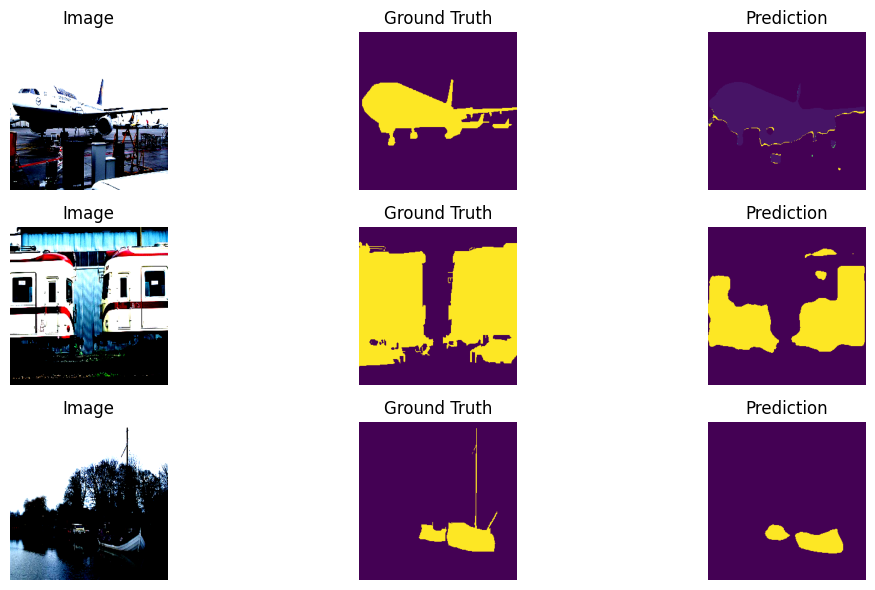

In [12]:
import matplotlib.pyplot as plt

model.eval()
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.argmax(preds, dim=1).cpu()

images = images.cpu()
masks = masks.cpu()

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(masks[i])
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(preds[i])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Собственная реализация модели U-Net

Была реализована кастомная модель сегментации на основе классической архитектуры **U-Net** без использования сторонних библиотек.

###  Основные компоненты модели:

- **Encoder (сжатие)** — четыре уровня свёрток с `ReLU` и `MaxPooling`, увеличивающие количество каналов и уменьшающие размер изображения.
- **Bottleneck** — самый глубокий уровень модели, обрабатывающий обобщённые признаки.
- **Decoder (расширение)** — транспонированные свёртки (`ConvTranspose2d`) и объединение (`concat`) с соответствующими слоями энкодера.
- **Final Layer** — свёртка `1x1` для приведения количества каналов к числу классов (21).

### Настройки обучения:

- **Функция потерь**: `CrossEntropyLoss` — подходит для многоклассовой пиксельной классификации.
- **Оптимизатор**: `Adam` с learning rate `1e-4`.


In [13]:
import torch.nn as nn
import torch

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_classes=21):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat([dec4, enc4], dim=1))

        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat([dec3, enc3], dim=1))

        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat([dec2, enc2], dim=1))

        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))

        return self.final(dec1)


In [14]:
simple_unet = UNet(in_channels=3, out_classes=21).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_unet.parameters(), lr=1e-4)

for epoch in range(20):
    simple_unet.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = simple_unet(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 282.9367
Epoch 2: Loss = 229.4560
Epoch 3: Loss = 221.7676
Epoch 4: Loss = 218.7543
Epoch 5: Loss = 217.8465
Epoch 6: Loss = 216.6503
Epoch 7: Loss = 215.6924
Epoch 8: Loss = 216.7912
Epoch 9: Loss = 213.4046
Epoch 10: Loss = 213.8128
Epoch 11: Loss = 210.9596
Epoch 12: Loss = 210.1129
Epoch 13: Loss = 208.7201
Epoch 14: Loss = 208.9281


KeyboardInterrupt: 

In [18]:
simple_unet.eval()
all_preds, all_masks = [], []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = simple_unet(images)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.append(preds)
        all_masks.append(masks)

all_preds = torch.cat(all_preds, dim=0)
all_masks = torch.cat(all_masks, dim=0)

iou, dice = evaluate_segmentation(all_preds, all_masks, num_classes=21)

print(f"Mean IoU: {iou:.4f}")
print(f"Mean Dice: {dice:.4f}")


Mean IoU: 0.0363
Mean Dice: 0.0421


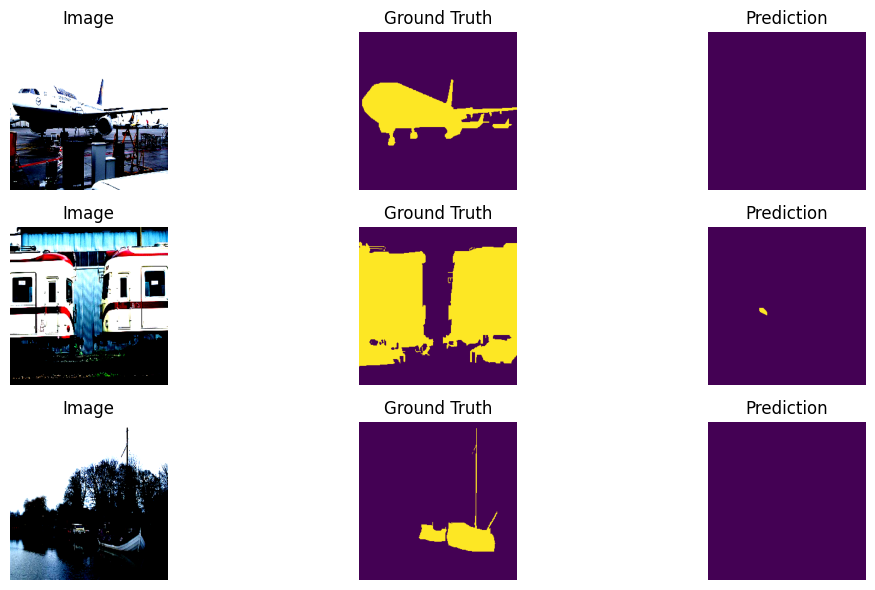

In [19]:
import matplotlib.pyplot as plt

simple_unet.eval()
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    preds = simple_unet(images)
    preds = torch.argmax(preds, dim=1).cpu()

images = images.cpu()
masks = masks.cpu()

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(masks[i])
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(preds[i])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
!pip install transformers datasets timm accelerate

['Requirement already satisfied: transformers in /usr/local/lib/python3.11/dist-packages (4.51.3)',
 'Requirement already satisfied: datasets in /usr/local/lib/python3.11/dist-packages (3.6.0)',
 'Requirement already satisfied: timm in /usr/local/lib/python3.11/dist-packages (1.0.15)',
 'Requirement already satisfied: accelerate in /usr/local/lib/python3.11/dist-packages (1.6.0)',
 'Requirement already satisfied: filelock in /usr/local/lib/python3.11/dist-packages (from transformers) (3.18.0)',
 'Requirement already satisfied: huggingface-hub<1.0,>=0.30.0 in /usr/local/lib/python3.11/dist-packages (from transformers) (0.30.2)',
 'Requirement already satisfied: numpy>=1.17 in /usr/local/lib/python3.11/dist-packages (from transformers) (2.0.2)',
 'Requirement already satisfied: packaging>=20.0 in /usr/local/lib/python3.11/dist-packages (from transformers) (24.2)',
 'Requirement already satisfied: pyyaml>=5.1 in /usr/local/lib/python3.11/dist-packages (from transformers) (6.0.2)',
 'Requi

## Модель сегментации на основе SegFormer

В данной части была реализована модель сегментации на базе архитектуры **SegFormer** с использованием библиотеки 🤗 `transformers`.

### Используемая модель:
- `nvidia/segformer-b0-finetuned-ade-512-512` — предобученная модель SegFormer (вариант B0), дообученная на датасете ADE20K.
- Модель адаптирована под **21 класс** (20 объектов + фон из VOC 2012).
- Аргумент `ignore_mismatched_sizes=True` позволяет корректно заменить выходной слой на нужное количество классов.

### Подготовка датасета:

- Используется `VOCSegmentation` (2012) с автоматической загрузкой.
- Для обработки изображений и масок используется `SegformerFeatureExtractor`, который:
  - масштабирует входы до 512×512,
  - нормализует и форматирует изображения,
  - кодирует сегментационные маски в нужном формате.

### Настройки обучения:

- **Оптимизатор**: `AdamW` с learning rate `2e-5`, что является стандартной практикой для обучения трансформеров.
- **Batch size**: 4


In [6]:
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)

class VOCSegformerDataset(torch.utils.data.Dataset):
    def __init__(self, root, year="2012", image_set="train"):
        self.voc = VOCSegmentation(root=root, year=year, image_set=image_set, download=True)

    def __getitem__(self, idx):
        img, mask = self.voc[idx]
        inputs = feature_extractor(images=img, segmentation_maps=mask, return_tensors="pt")
        return {
            "pixel_values": inputs["pixel_values"].squeeze(),
            "labels": inputs["labels"].squeeze().long()
        }

    def __len__(self):
        return len(self.voc)


/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [ ]:
train_dataset = VOCSegformerDataset(root="data", image_set="train")
val_dataset = VOCSegformerDataset(root="data", image_set="val")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


In [8]:
from transformers import SegformerForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=21,
    ignore_mismatched_sizes=True  # важно, если классов не совпадает
)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([21]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([21, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")


Epoch 1/3 - Loss: 987.2418
Epoch 2/3 - Loss: 748.6643
Epoch 3/3 - Loss: 613.1280


Метрики посчитаны не были, падало с ошибкой по ОЗУ

## Внесённые улучшения

Для повышения качества сегментации и устойчивости модели были внесены следующие улучшения:

### Аугментация данных:

Обучающие изображения проходят расширенный набор преобразований:

- изменение размера до 256×256 пикселей;
- случайное горизонтальное отражение (с вероятностью 50%);
- случайное изменение яркости и контраста (30%);
- случайное смещение, масштабирование и поворот изображения (до 5% и 15°);
- нормализация и преобразование в тензор.

> Эти трансформации делают модель устойчивой к искажениям, поворотам и изменениям освещения.

###  Модель:

- Использована более мощная архитектура — `Unet` с энкодером `EfficientNet-B3`, предобученным на ImageNet.
- Поддержка 21 класса (включая фон).

### Обучение:

- **Функция потерь**: `DiceLoss` в режиме `multiclass` — подходит для многоклассовой сегментации и лучше работает при дисбалансе классов.
- **Оптимизатор**: `AdamW` с `learning rate = 1e-4` и регуляризацией (`weight_decay = 1e-4`).
- **Планировщик обучения**: `CosineAnnealingLR` — плавно уменьшает learning rate по косинусной кривой, что помогает улучшить сходимость.

> В совокупности эти улучшения позволяют добиться более стабильного и качественного обучения модели.


In [2]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = VOCDataset(root='data', image_set='train', transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Модель
model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=21  # 20 классов + фон
).to(device)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [14]:
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

loss_fn = DiceLoss(mode="multiclass")

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [15]:
for epoch in range(20):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}: Train loss = {train_loss:.4f}")


Epoch 1: Train loss = 69.4860
Epoch 2: Train loss = 63.5395
Epoch 3: Train loss = 61.1041
Epoch 4: Train loss = 56.2720
Epoch 5: Train loss = 54.5812
Epoch 6: Train loss = 51.9437
Epoch 7: Train loss = 50.3363
Epoch 8: Train loss = 48.4730
Epoch 9: Train loss = 48.1684
Epoch 10: Train loss = 47.5096
Epoch 11: Train loss = 47.7565
Epoch 12: Train loss = 48.4429
Epoch 13: Train loss = 46.7914
Epoch 14: Train loss = 46.8823
Epoch 15: Train loss = 45.6829
Epoch 16: Train loss = 45.5158
Epoch 17: Train loss = 43.9980
Epoch 18: Train loss = 42.7011
Epoch 19: Train loss = 39.1592
Epoch 20: Train loss = 38.4973


In [16]:
model.eval()
all_preds, all_masks = [], []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.append(preds)
        all_masks.append(masks)

all_preds = torch.cat(all_preds, dim=0)
all_masks = torch.cat(all_masks, dim=0)

iou, dice = evaluate_segmentation(all_preds, all_masks, num_classes=21)

print(f"Mean IoU: {iou:.4f}")
print(f"Mean Dice: {dice:.4f}")


Mean IoU: 0.4626
Mean Dice: 0.5703


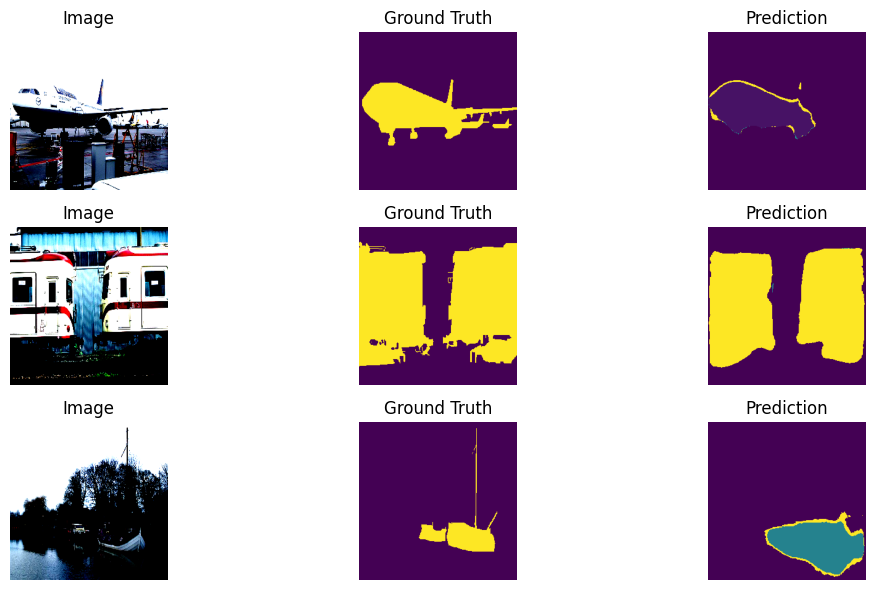

In [17]:
import matplotlib.pyplot as plt

model.eval()
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.argmax(preds, dim=1).cpu()

images = images.cpu()
masks = masks.cpu()

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(masks[i])
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(preds[i])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Улучшенная реализация U-Net (ImprovedUNet)

Для повышения качества сегментации была реализована собственная улучшенная архитектура U-Net с дополнительными мерами регуляризации.

###  Основные улучшения по сравнению с базовым U-Net:

- **Batch Normalization** после каждой сверточной операции — ускоряет обучение и стабилизирует градиенты.
- **Dropout** (в декодере) — добавлен после глубоких слоёв, чтобы уменьшить переобучение.
- **Структура**: сохранена классическая U-Net-архитектура с энкодером, bottleneck и декодером, использующим skip-соединения.

###  Компоненты модели:

- **Encoder**: четыре блока `conv → BN → ReLU`, каждый с `MaxPooling`, увеличивая глубину признаков.
- **Bottleneck**: наиболее глубокий уровень признаков с 1024 каналами.
- **Decoder**: транспонированные свёртки (`ConvTranspose2d`) для восстановления размера + skip-соединения с энкодером.
- **Dropout**: используется в глубоких декодерах (`dec3`, `dec4`) для регуляризации.
- **Выходной слой**: `Conv2d` с ядром 1×1 для приведения к нужному количеству классов (21).

> Эта улучшенная модель лучше справляется с переобучением и может показать более стабильные результаты на сложных выборках.


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedUNet(nn.Module):
    def __init__(self, in_channels=3, out_classes=21):
        super(ImprovedUNet, self).__init__()

        def conv_block(in_ch, out_ch, dropout=False):
            layers = [
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            ]
            if dropout:
                layers.append(nn.Dropout(0.3))
            return nn.Sequential(*layers)

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.dec4 = conv_block(1024, 512, dropout=True)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = conv_block(512, 256, dropout=True)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))

        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))

        return self.final(d1)


In [19]:
model = ImprovedUNet(in_channels=3, out_classes=21).to(device)

# Функция потерь (Dice)
criterion = DiceLoss(mode='multiclass')

# Оптимизатор + scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [20]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}")

    # Валидация
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"→ Val Loss: {val_loss:.4f}\n")


Epoch 1/5 | Train Loss: 77.2161
→ Val Loss: 74.9582\n
Epoch 2/5 | Train Loss: 74.7361
→ Val Loss: 73.6377\n
Epoch 3/5 | Train Loss: 71.8612
→ Val Loss: 73.1421\n
Epoch 4/5 | Train Loss: 71.8472
→ Val Loss: 72.1182\n
Epoch 5/5 | Train Loss: 71.1495
→ Val Loss: 70.9872\n


In [21]:
model.eval()
all_preds, all_masks = [], []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.append(preds)
        all_masks.append(masks)

all_preds = torch.cat(all_preds, dim=0)
all_masks = torch.cat(all_masks, dim=0)

iou, dice = evaluate_segmentation(all_preds, all_masks, num_classes=21)

print(f"Mean IoU: {iou:.4f}")
print(f"Mean Dice: {dice:.4f}")


Mean IoU: 0.0519
Mean Dice: 0.0749


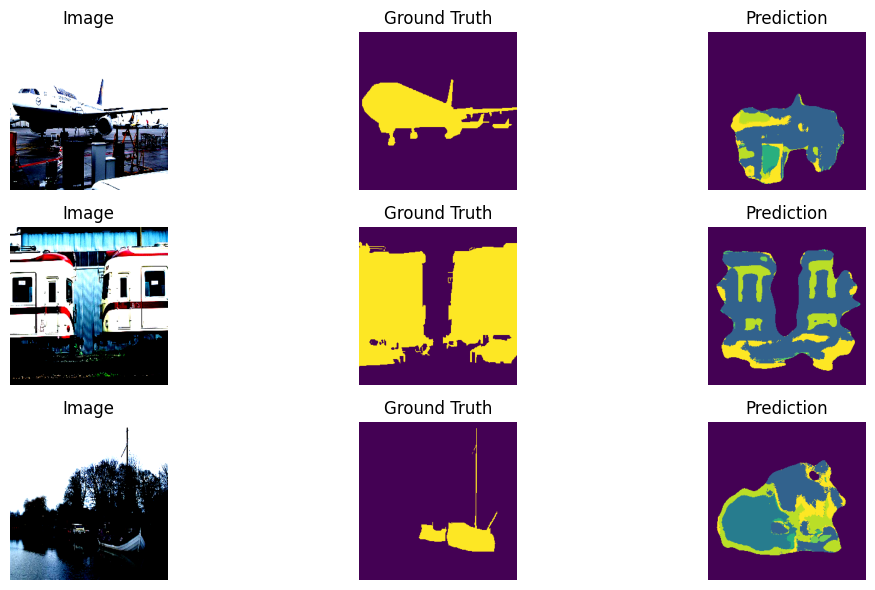

In [22]:
import matplotlib.pyplot as plt

model.eval()
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    preds = model(images)
    preds = torch.argmax(preds, dim=1).cpu()

images = images.cpu()
masks = masks.cpu()

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.title("Image")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(masks[i])
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(preds[i])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()
